<a href="https://colab.research.google.com/github/LiorProjects2024/Bird-vs.-Drone-Classification/blob/main/Bird-vs.-Drone-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install --upgrade tensorflow

In [5]:
!pip install split-folders

In [ ]:
#הוספת סיפריות רלוונטיות
import os
import time
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import splitfolders
from google.colab import drive
import tensorflow as tf
import numpy as np
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# חיבור המחברת לתיקייה בדרייב שבא מאוחסנות התמונות
drive.mount('/content/drive')
input_folder = '/content/drive/My Drive/final_project/ver1'
output_folder = '/content/drive/My Drive/final_project/ver1_output'
if not os.path.exists(input_folder):
    raise FileNotFoundError(f"Input folder '{input_folder}' not found. Please check your path.")

# פונקציהב של מחיקת הקובץ הישן כל הרצה כך שלא יגרם תקלות
def reset_output_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    time.sleep(120)  # המתנה של שתי דקות שהמחיקה תתבצע כמו שצריך

# משתנים והיפר פרמטרים
epochs = 30
batch_size = 32
image_size = (224, 224)
all_accuracies = []
all_confusion_matrices = []
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

# טעינה של העשר הרצות
for seed in range(10):
    print(f"Running iteration {seed + 1}/10 with seed {seed}")


    reset_output_folder(output_folder)

 #פתיחת התקייה או כניסה לתיקייה שבא תשמרנה התמונות ביחס החלוקה :70% אימון,20% ולידציה , 10% מבחן
    import splitfolders
    splitfolders.ratio(input_folder, output=output_folder, seed=seed, ratio=(0.7, 0.2, 0.1))
    time.sleep(120)  # המתנה של שתי דקות לוודא שכל התיקיות עלו כמו שצריך

#יצירת שינויים בתמונות להגדלת תבניות של האובייקטים ליצירת שינוי מלאכותי , שינוי היפר פרמטרים של האימון
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        brightness_range=[0.8, 1.2],
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(output_folder, 'train'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=seed
    )
    validation_generator = test_val_datagen.flow_from_directory(
        os.path.join(output_folder, 'val'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    test_generator = test_val_datagen.flow_from_directory(
        os.path.join(output_folder, 'test'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    #טעינת המודל ללא השכבה העליונה
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    #השארת שאר המשקלים של שאר השכבות כמו שהם על מנת שלא ישתנו במהלך הלמידה
    base_model.trainable = False
    # הוספת שכבות חדשות במקום השכבה האחרונה
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.15),
        Dense(1, activation='sigmoid')
    ])
    # בחירת אופטימיזר והיפר פרמטרים שלו
    model.compile(optimizer=Adam(learning_rate=7e-5), loss='binary_crossentropy', metrics=['accuracy'])

    # אימון השכבות שהוספנו
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)]
    )

    #שמירת הנתונים על מנת שנוכל למצע בסוף
    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])
    # בחינת סדרת המבחן ושמירה של הנתונים
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test accuracy for iteration {seed + 1}: {test_acc:.2f}")
    all_accuracies.append(test_acc)

    # שמירת נתונים של המטריצת עירבול
    Y_pred = model.predict(test_generator)
    y_pred = np.round(Y_pred).astype(int)
    y_true = test_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    all_confusion_matrices.append(cm)


    reset_output_folder(output_folder)

Mounted at /content/drive
Running iteration 1/10 with seed 0


Copying files: 802 files [00:32, 24.62 files/s]


Found 559 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 81 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5967 - loss: 0.6707 - val_accuracy: 0.8188 - val_loss: 0.4728 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7393 - loss: 0.5250 - val_accuracy: 0.8875 - val_loss: 0.3892 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8652 - loss: 0.4102 - val_accuracy: 0.9000 - val_loss: 0.3300 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8565 - loss: 0.3630 - val_accuracy: 0.8938 - val_loss: 0.2926 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8678 - loss: 0.3412 - val_accuracy: 0.9062 - val_loss: 0.2709 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9085 - loss: 0.2907 - val_accuracy: 0.9125 - val_loss: 0.2473 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9249 - loss:

Copying files: 802 files [00:17, 45.41 files/s]


Found 560 images belonging to 2 classes.
Found 159 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.5133 - loss: 1.0775 - val_accuracy: 0.5786 - val_loss: 0.6967 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6190 - loss: 0.6575 - val_accuracy: 0.7107 - val_loss: 0.5641 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7069 - loss: 0.5367 - val_accuracy: 0.7736 - val_loss: 0.4899 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8443 - loss: 0.4193 - val_accuracy: 0.7925 - val_loss: 0.4415 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8470 - loss: 0.3711 - val_accuracy: 0.8176 - val_loss: 0.4020 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8517 - loss: 0.3469 - val_accuracy: 0.8239 - val_loss: 0.3739 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8750 - loss:

Copying files: 802 files [00:16, 48.32 files/s]


Found 559 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5656 - loss: 0.8032 - val_accuracy: 0.7063 - val_loss: 0.5661 - learning_rate: 7.0000e-05
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7170 - loss: 0.5544 - val_accuracy: 0.8250 - val_loss: 0.4545 - learning_rate: 7.0000e-05
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8148 - loss: 0.4482 - val_accuracy: 0.8375 - val_loss: 0.3902 - learning_rate: 7.0000e-05
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8708 - loss: 0.3618 - val_accuracy: 0.8625 - val_loss: 0.3454 - learning_rate: 7.0000e-05
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8887 - loss: 0.3510 - val_accuracy: 0.8750 - val_loss: 0.3199 - learning_rate: 7.0000e-05
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8845 - loss: 0.3231 - val_accuracy: 0.9000 - val_loss: 0.2915 - learning_rate: 7.0000e-05
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9144 - loss:

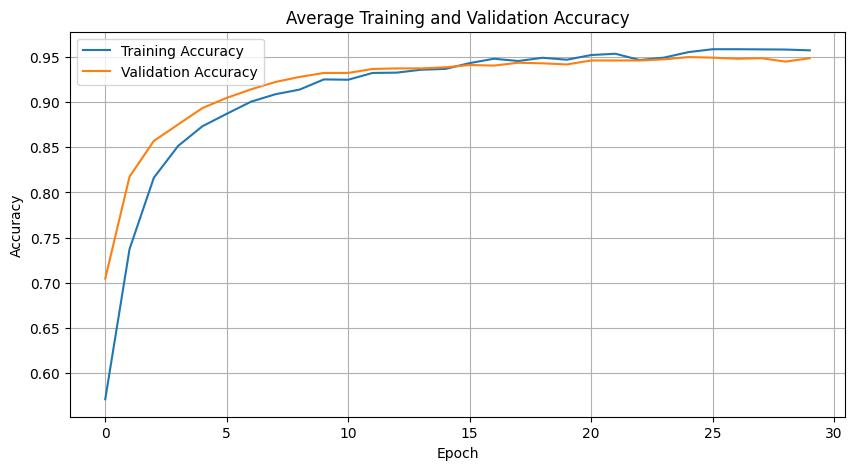

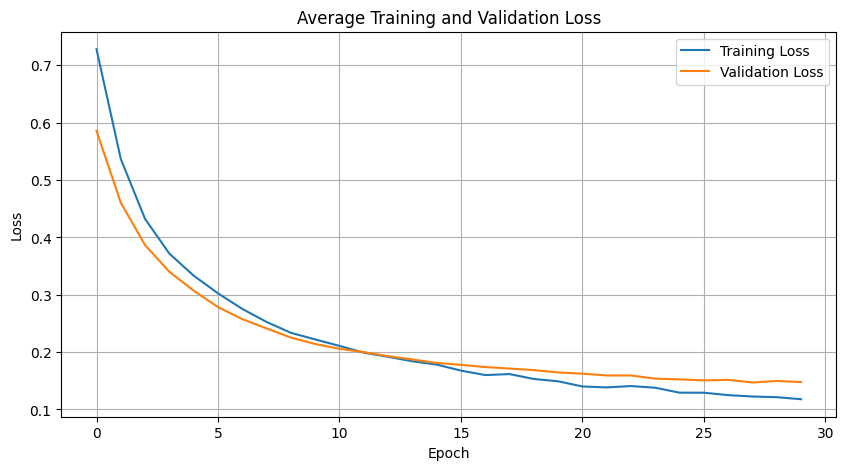

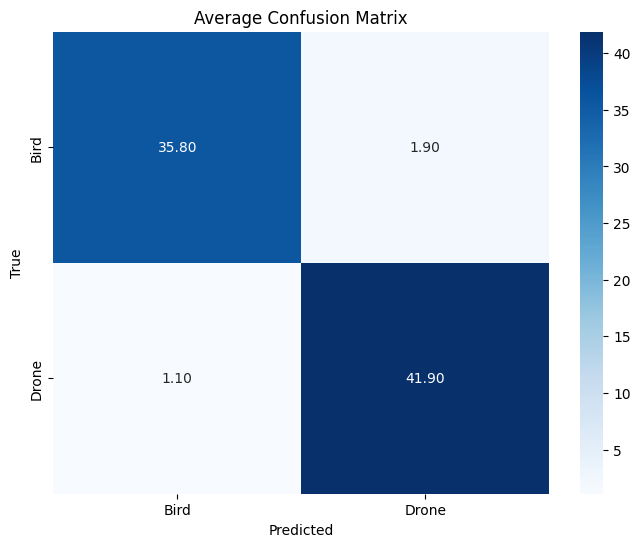

Average test accuracy across all runs: 0.96


In [ ]:
#חישובי הממוצעים ויצירת הגרפים ומטריצת העירבול
average_train_acc = np.mean(all_train_acc, axis=0)
average_val_acc = np.mean(all_val_acc, axis=0)
average_train_loss = np.mean(all_train_loss, axis=0)
average_val_loss = np.mean(all_val_loss, axis=0)


plt.figure(figsize=(10, 5))
plt.plot(average_train_acc, label='Training Accuracy')
plt.plot(average_val_acc, label='Validation Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(average_train_loss, label='Training Loss')
plt.plot(average_val_loss, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


target_names = ['Bird', 'Drone']

average_cm = np.mean(all_confusion_matrices, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()

average_accuracy = np.mean(all_accuracies)
print(f"Average test accuracy across all runs: {average_accuracy:.2f}")


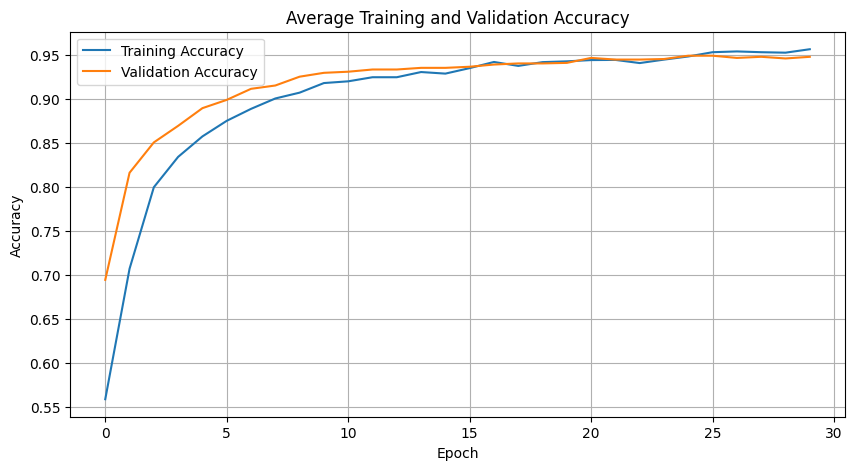

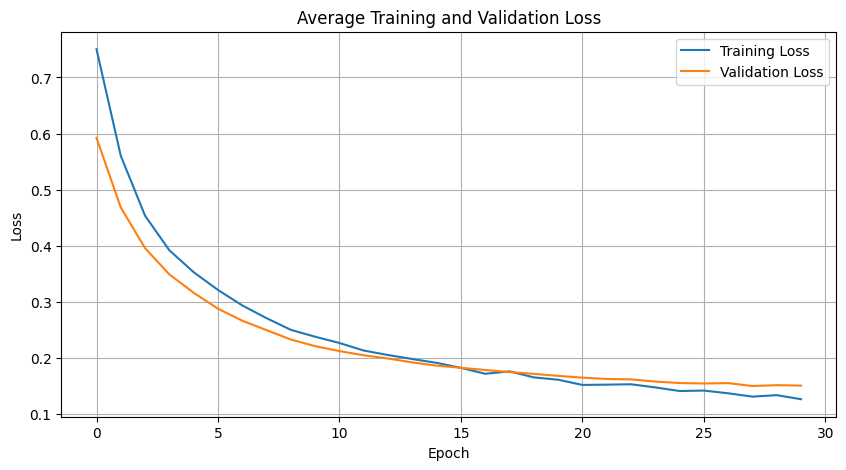

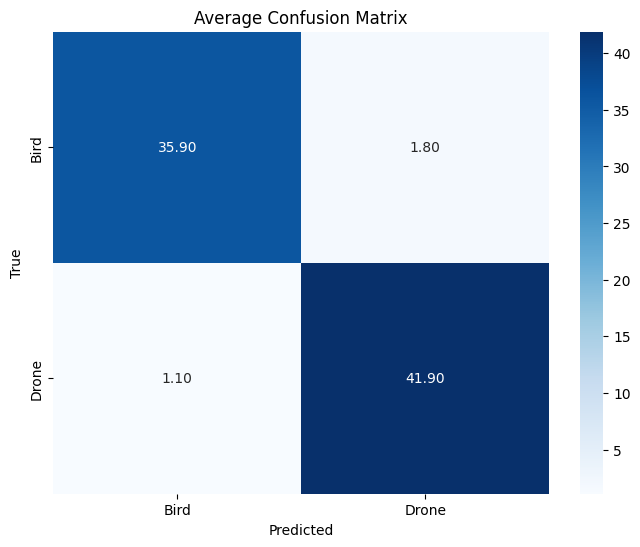

Average test accuracy across all runs: 0.96


In [ ]:
#חישובי הממוצעים ויצירת הגרפים ומטריצת העירבול
average_train_acc = np.mean(all_train_acc, axis=0)
average_val_acc = np.mean(all_val_acc, axis=0)
average_train_loss = np.mean(all_train_loss, axis=0)
average_val_loss = np.mean(all_val_loss, axis=0)


plt.figure(figsize=(10, 5))
plt.plot(average_train_acc, label='Training Accuracy')
plt.plot(average_val_acc, label='Validation Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(average_train_loss, label='Training Loss')
plt.plot(average_val_loss, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


target_names = ['Bird', 'Drone']

average_cm = np.mean(all_confusion_matrices, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()

average_accuracy = np.mean(all_accuracies)
print(f"Average test accuracy across all runs: {average_accuracy:.2f}")


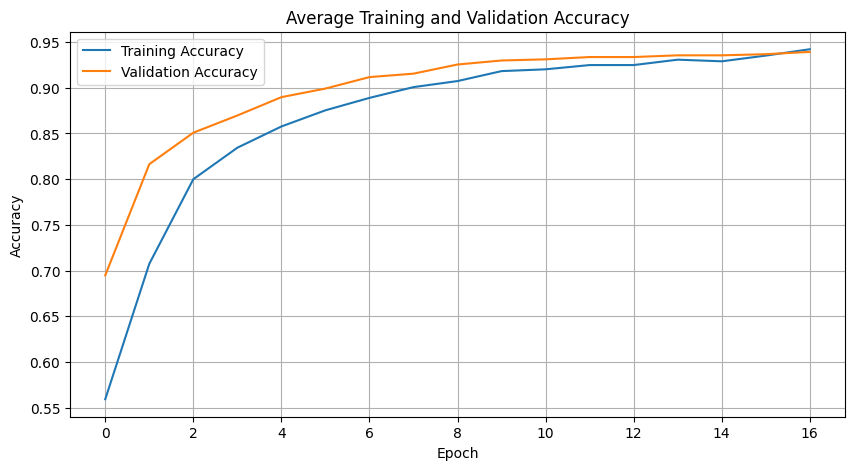

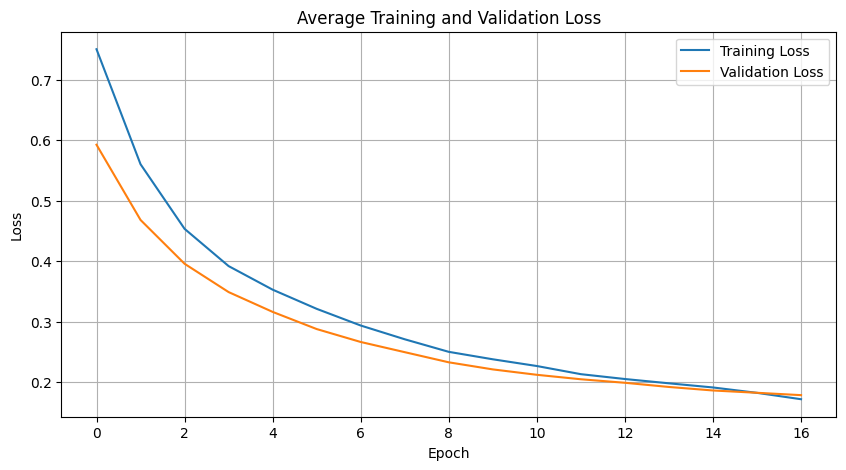

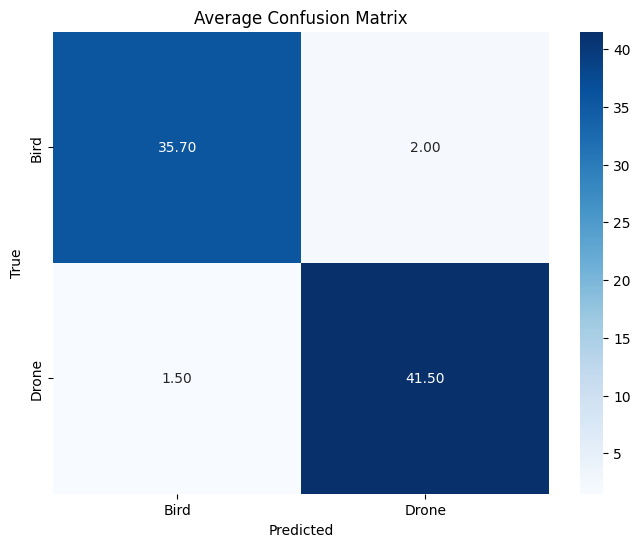

Average test accuracy across all runs: 0.96


In [ ]:
#חישובי הממוצעים ויצירת הגרפים ומטריצת העירבול
average_train_acc = np.mean(all_train_acc, axis=0)
average_val_acc = np.mean(all_val_acc, axis=0)
average_train_loss = np.mean(all_train_loss, axis=0)
average_val_loss = np.mean(all_val_loss, axis=0)


plt.figure(figsize=(10, 5))
plt.plot(average_train_acc, label='Training Accuracy')
plt.plot(average_val_acc, label='Validation Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(average_train_loss, label='Training Loss')
plt.plot(average_val_loss, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


target_names = ['Bird', 'Drone']

average_cm = np.mean(all_confusion_matrices, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()

average_accuracy = np.mean(all_accuracies)
print(f"Average test accuracy across all runs: {average_accuracy:.2f}")


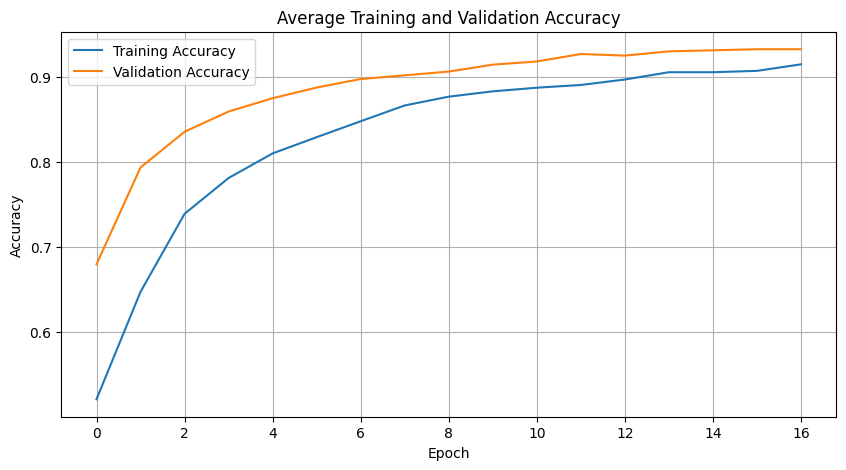

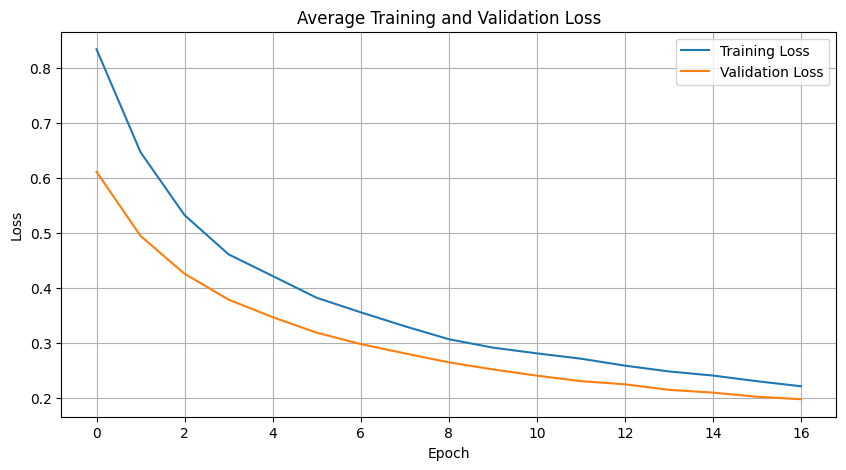

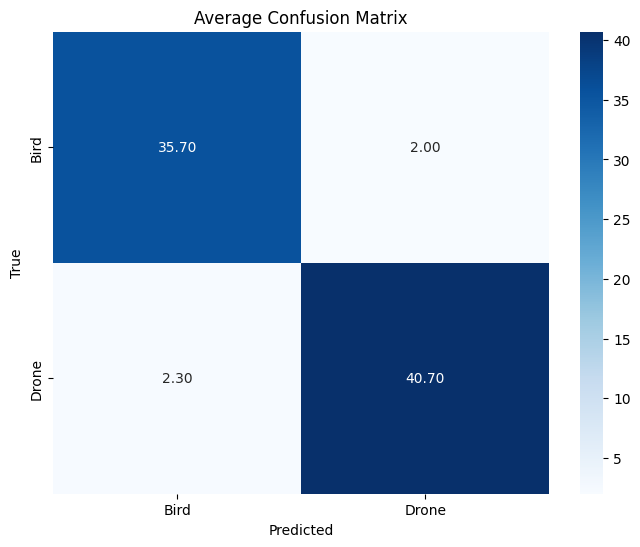

Average test accuracy across all runs: 0.95


In [ ]:
#חישובי הממוצעים ויצירת הגרפים ומטריצת העירבול
average_train_acc = np.mean(all_train_acc, axis=0)
average_val_acc = np.mean(all_val_acc, axis=0)
average_train_loss = np.mean(all_train_loss, axis=0)
average_val_loss = np.mean(all_val_loss, axis=0)


plt.figure(figsize=(10, 5))
plt.plot(average_train_acc, label='Training Accuracy')
plt.plot(average_val_acc, label='Validation Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(average_train_loss, label='Training Loss')
plt.plot(average_val_loss, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


target_names = ['Bird', 'Drone']

average_cm = np.mean(all_confusion_matrices, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()

average_accuracy = np.mean(all_accuracies)
print(f"Average test accuracy across all runs: {average_accuracy:.2f}")


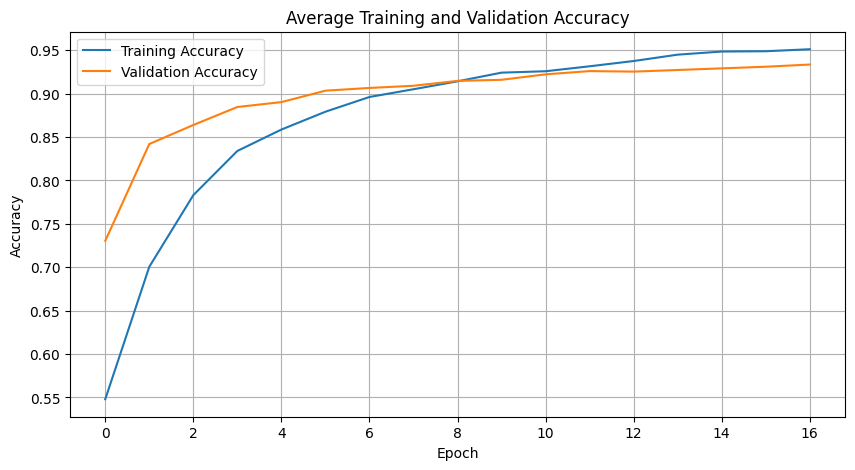

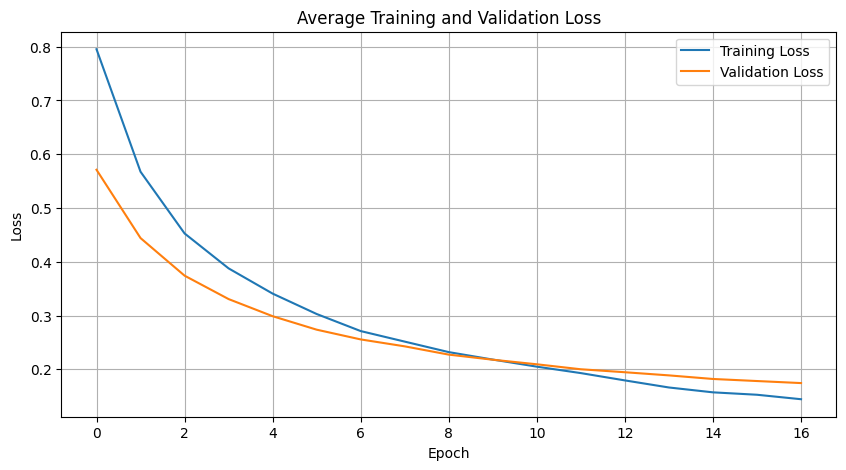

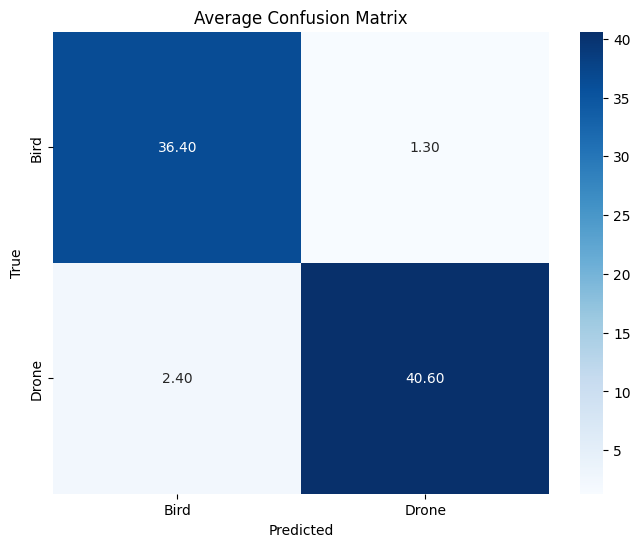

Average test accuracy across all runs: 0.95


In [ ]:
#חישובי הממוצעים ויצירת הגרפים ומטריצת העירבול
average_train_acc = np.mean(all_train_acc, axis=0)
average_val_acc = np.mean(all_val_acc, axis=0)
average_train_loss = np.mean(all_train_loss, axis=0)
average_val_loss = np.mean(all_val_loss, axis=0)


plt.figure(figsize=(10, 5))
plt.plot(average_train_acc, label='Training Accuracy')
plt.plot(average_val_acc, label='Validation Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(average_train_loss, label='Training Loss')
plt.plot(average_val_loss, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


target_names = ['Bird', 'Drone']

average_cm = np.mean(all_confusion_matrices, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()

average_accuracy = np.mean(all_accuracies)
print(f"Average test accuracy across all runs: {average_accuracy:.2f}")


In [ ]:
#חישובי הממוצעים ויצירת הגרפים ומטריצת העירבול
average_train_acc = np.mean(all_train_acc, axis=0)
average_val_acc = np.mean(all_val_acc, axis=0)
average_train_loss = np.mean(all_train_loss, axis=0)
average_val_loss = np.mean(all_val_loss, axis=0)


plt.figure(figsize=(10, 5))
plt.plot(average_train_acc, label='Training Accuracy')
plt.plot(average_val_acc, label='Validation Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(average_train_loss, label='Training Loss')
plt.plot(average_val_loss, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


target_names = ['Bird', 'Drone']

average_cm = np.mean(all_confusion_matrices, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()

average_accuracy = np.mean(all_accuracies)
print(f"Average test accuracy across all runs: {average_accuracy:.2f}")
